In [ ]:
import pandas as pd
import numpy as np
from sklearn.manifold import MDS
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import adjusted_rand_score


In [ ]:
import pandas as pd
import numpy as np
spotify_songs = pd.read_csv('https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2020/2020-01-21/spotify_songs.csv')
Q1 = np.percentile(spotify_songs.duration_ms, 25,
                   interpolation = 'midpoint')
Q3 = np.percentile(spotify_songs.duration_ms, 75,
                   interpolation = 'midpoint')
IQR = Q3 - Q1
mask = (spotify_songs.duration_ms < (Q3+1.5*IQR))
mask2 = spotify_songs.duration_ms > (Q1-1.5*IQR)
spotify_data_cleaned = spotify_songs.loc[mask]
spotify_data_cleaned = spotify_data_cleaned.loc[mask2]
spotify_data_cleaned.track_album_release_date.str[:4]
spotify_data_cleaned.track_album_release_date.str[5:7]
spotify_data_cleaned = spotify_data_cleaned.assign(
    track_album_release_month = spotify_data_cleaned.track_album_release_date.str[5:7],
    track_album_release_year = spotify_data_cleaned.track_album_release_date.str[:4],
)
mask1 = spotify_data_cleaned.track_popularity <= 80
mask2 = spotify_data_cleaned.track_popularity <=60
mask3 = spotify_data_cleaned.track_popularity <=40
mask4 = spotify_data_cleaned.track_popularity <=20

spotify_data_cleaned["popularity_quali"] = "trèsPopulaire"
spotify_data_cleaned.loc[mask1,"popularity_quali"] = "bienPopulaire"
spotify_data_cleaned.loc[mask2,"popularity_quali"] = "moyennementPopulaire"
spotify_data_cleaned.loc[mask3,"popularity_quali"] = "bofPopulaire"
spotify_data_cleaned.loc[mask4,"popularity_quali"] = "pasPopulaire"

spotify_data_cleaned.drop(columns="track_album_release_date",inplace=True)
mask = (spotify_data_cleaned.track_popularity > 0)
spotify_data_cleaned = spotify_data_cleaned.loc[mask]
#bon en vrai ca marche bien pour 100 mais pas pour tous mais flemme de faire une belle fonction mdr on verra si on a le temps
def spotify_data_short(nbTrackByGenre):
    spotify_data_short = pd.concat((spotify_data_cleaned[5000:5000+nbTrackByGenre],spotify_data_cleaned[10000:10000+nbTrackByGenre],spotify_data_cleaned[15000:15000+nbTrackByGenre],spotify_data_cleaned[20000:20000+nbTrackByGenre],spotify_data_cleaned[25000:25000+nbTrackByGenre]), axis=0)
    return spotify_data_short
    short = spotify_data_short(100)
short = spotify_data_short(100)
spotify_data_quanti = short[["track_popularity","danceability","energy","loudness","speechiness","acousticness","instrumentalness","liveness","valence","tempo","duration_ms"]]
data = spotify_data_cleaned[["track_popularity","danceability","energy","loudness","speechiness","acousticness","instrumentalness","liveness","valence","tempo","duration_ms"]]


In [ ]:
aftd = MDS(n_components=5,dissimilarity="euclidean")
dist = aftd.fit_transform(spotify_data_quanti)
dist

array([[ 44235.60482559,  -5794.06238001, -21720.91816356,
         13662.03252124,  -9589.3757746 ],
       [ 23369.57615675,  -2929.17581403, -12690.81247755,
          7911.42008167,  -5667.49298273],
       [103240.19016585, -18012.92262163, -50944.59751884,
         40465.04317995, -23789.45165675],
       ...,
       [-67723.00860776,   7141.96062752,  37072.96052842,
        -22712.93612974,  20302.82359499],
       [-71188.97083214,   8275.55376971,  38721.54618211,
        -26358.52059553,  20777.23128648],
       [ -7993.23887215,   1867.19917154,   3478.43266192,
         -2911.05108116,   1350.42506318]])

<AxesSubplot:>

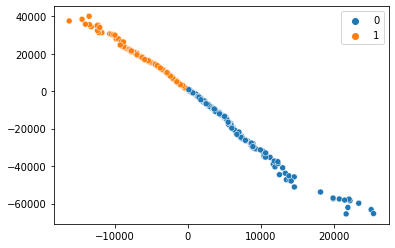

In [ ]:
cls = AgglomerativeClustering(linkage="ward", affinity="euclidean")
cls.fit(spotify_data_quanti)
labels = cls.labels_

aftd = MDS(n_components=5,dissimilarity="euclidean")
dist = aftd.fit_transform(spotify_data_quanti)

sns.scatterplot(
    x=dist[:,0],
    y=dist[:,1],
    hue=labels

)

#add_labels(dist[:,0],dist[:,1],spotify_data_quanti.index)


In [ ]:
cls = KMeans(n_clusters=5, init="k-means++")
cls.fit(spotify_data_quanti)

KMeans(n_clusters=5)

In [ ]:
def scatterplot_pca(
    
    columns=None, hue=None, style=None, data=None, pc1=1, pc2=2, **kwargs
):
    """Diagramme de dispersion dans le premier plan principal.

    Permet d'afficher un diagramme de dispersion lorsque les données
    ont plus de deux dimensions. L'argument `columns` spécifie la
    liste des colonnes à utiliser pour la PCA dans le jeu de données
    `data`. Les arguments `style` et `hue` permettent de spécifier la
    forme et la couleur des marqueurs. Les arguments `pc1` et `pc2`
    permettent de sélectionner les composantes principales (par défaut
    la première et deuxième). Retourne l'objet `Axes` ainsi que le
    modèle `PCA` utilisé pour réduire la dimension.

    :param columns: Les colonnes quantitatives de `data` à utiliser
    :param hue: La colonne de coloration
    :param style: La colonne du style
    :param data: Le dataFrame Pandas
    :param pc1: La composante en abscisse
    :param pc2: La composante en ordonnée

    """
     # Select relevant columns (should be numeric)
    data_quant = data if columns is None else data[columns]
    data_quant = data_quant.drop(
        columns=[e for e in [hue, style] if e is not None], errors="ignore"
    )

    # Reduce to two dimensions if needed
    if data_quant.shape[1] == 2:
        data_pca = data_quant
        pca = None
    else:
        n_components = max(pc1, pc2)
        pca = PCA(n_components=n_components)
        data_pca = pca.fit_transform(data_quant)
        data_pca = pd.DataFrame(
            data_pca[:, [pc1 - 1, pc2 - 1]], columns=[f"PC{pc1}", f"PC{pc2}"]
        )

    # Keep name, force categorical data for hue and steal index to
    # avoid unwanted alignment
    if isinstance(hue, pd.Series):
        if not hue.name:
            hue.name = "hue"
        hue_name = hue.name
    elif isinstance(hue, str):
        hue_name = hue
        hue = data[hue]
    elif isinstance(hue, np.ndarray):
        hue = pd.Series(hue, name="class")
        hue_name = "class"

    hue = hue.astype("category")
    hue.index = data_pca.index
    hue.name = hue_name

    if isinstance(style, pd.Series):
        if not style.name:
            style.name = "style"
        style_name = style.name
    elif isinstance(style, str):
        style_name = style
        style = data[style]
    elif isinstance(style, np.ndarray):
        style = pd.Series(style, name="style")
        style_name = "style"

    full_data = data_pca
    if hue is not None:
        full_data = pd.concat((full_data, hue), axis=1)
        kwargs["hue"] = hue_name
    if style is not None:
        full_data = pd.concat((full_data, style), axis=1)
        kwargs["style"] = style_name

    x, y = data_pca.columns
    ax = sns.scatterplot(x=x, y=y, data=full_data, **kwargs)

    return ax, pca

(<AxesSubplot:xlabel='PC1', ylabel='PC2'>, PCA(n_components=2))

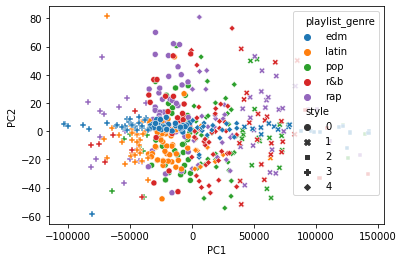

In [ ]:
scatterplot_pca(data=spotify_data_quanti,style=cls.labels_,hue=short.playlist_genre)

In [ ]:
adjusted_rand_score(cls.labels_, short.playlist_genre)

0.03958531476482667

(<AxesSubplot:xlabel='PC1', ylabel='PC2'>, PCA(n_components=2))

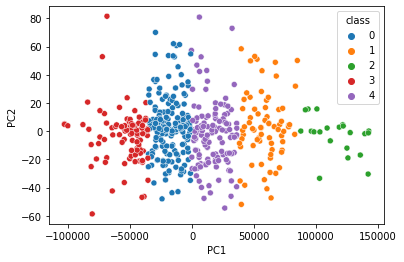

In [ ]:
scatterplot_pca(data=spotify_data_quanti,hue=cls.labels_,)

(<AxesSubplot:xlabel='PC1', ylabel='PC2'>, PCA(n_components=2))

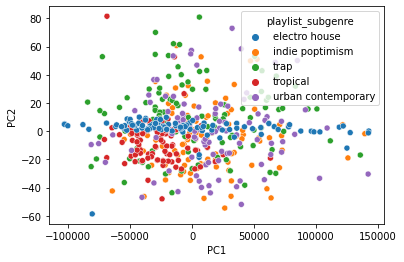

In [ ]:
scatterplot_pca(data=spotify_data_quanti,hue=short.playlist_subgenre)

(<AxesSubplot:xlabel='PC1', ylabel='PC2'>, PCA(n_components=2))

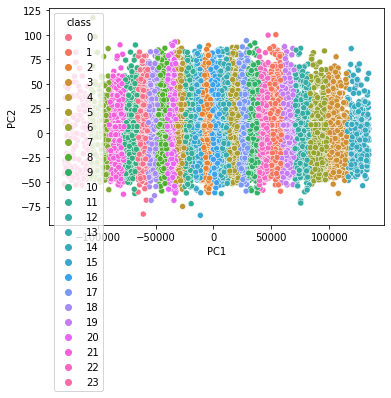

In [ ]:
cls = KMeans(n_clusters=24, init="k-means++")
cls.fit(data)
scatterplot_pca(data=data,hue=cls.labels_)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=c2ad4461-7f35-42f5-b2d9-f686e8952f67' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>